## Bibiliothèque

In [26]:
import numpy as np
import tensorflow as tf;
import matplotlib.pyplot as plt
from resnet import resnet_v2
import time
%matplotlib inline
seed = tf.random.set_seed(10)


In [27]:
def plot_hist(figname):
    plt.figure(figsize=(15,7))
    plt.subplot(121)
    plt.plot(accuracy, label = "train accuracy")
    plt.plot(val_accuracy, label = "validation accuracy")
    plt.title("Accuracy")
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(l, label = "train loss")
    plt.plot(val_l, label = "validation loss")
    plt.title("Loss")
    plt.grid()
    plt.legend()

    plt.savefig(figname)
    plt.show()
    
def inference_time():
    scratch = []
    pruned = []
    for i in range(10):
        t1 = time.time()
        pred1 = scratch_model(x_test)
        t2 = time.time()
        scratch.append(t2-t1)

        # Pruned model
        t3 = time.time()
        pred2 = P.model(x_test)
        t4 = time.time()
        pruned.append(t4-t3)

    # display
    print("Scratch inference time : ", np.mean(scratch), " s")
    print("Pruned inference time : ", np.mean(pruned), " s")
    return np.mean(pruned)


def count_parameters(model):
    somme = 0
    for l in model.trainable_variables:
        somme += np.count_nonzero(l)
    return somme


def scratch_hist():   
    loss = dico["scratch_hist"][0].history["loss"]
    val_loss = dico["scratch_hist"][0].history["val_loss"]
    accuracy = dico["scratch_hist"][0].history["sparse_categorical_accuracy"]
    val_accuracy =  dico["scratch_hist"][0].history["val_sparse_categorical_accuracy"]

    for i in range(len( dico["scratch_hist"])):
        if i !=0:
            loss = np.append(loss, dico["scratch_hist"][i].history["loss"])
            val_loss = np.append(val_loss, dico["scratch_hist"][i].history["val_loss"])
            accuracy = np.append(accuracy, dico["scratch_hist"][i].history["sparse_categorical_accuracy"])
            val_accuracy =  np.append(val_accuracy, dico["scratch_hist"][i].history["val_sparse_categorical_accuracy"])

    dico["scratch_hist"] = (accuracy, val_accuracy, loss, val_loss)

## Loading cifar10 Dataset

In [28]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Building Resnet8 model 

In [30]:
model = resnet_v2((32, 32, 3), depth = 50)

model.summary();

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_84 (Conv2D)             (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_76 (BatchN  (None, 32, 32, 16)  64          ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_76[0]

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 32, 32, 16)   2320        ['activation_85[0][0]']          
                                                                                                  
 batch_normalization_86 (BatchN  (None, 32, 32, 16)  64          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_40 (Add)                   (None, 32, 32, 16)   0           ['activation_84[0][0]',          
          

                                                                                                  
 conv2d_104 (Conv2D)            (None, 16, 16, 32)   9248        ['activation_94[0][0]']          
                                                                                                  
 batch_normalization_95 (BatchN  (None, 16, 16, 32)  128         ['conv2d_104[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_95 (Activation)     (None, 16, 16, 32)   0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 conv2d_105 (Conv2D)            (None, 16, 16, 32)   9248        ['activation_95[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_104 (Activation)    (None, 16, 16, 32)   0           ['add_49[0][0]']                 
                                                                                                  
 conv2d_114 (Conv2D)            (None, 16, 16, 32)   9248        ['activation_104[0][0]']         
                                                                                                  
 batch_normalization_105 (Batch  (None, 16, 16, 32)  128         ['conv2d_114[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_105 (Activation)    (None, 16, 16, 32)   0           ['batch_normalization_105[0][0]']
                                                                                                  
 conv2d_11

 Normalization)                                                                                   
                                                                                                  
 add_54 (Add)                   (None, 8, 8, 64)     0           ['activation_112[0][0]',         
                                                                  'batch_normalization_114[0][0]']
                                                                                                  
 activation_114 (Activation)    (None, 8, 8, 64)     0           ['add_54[0][0]']                 
                                                                                                  
 conv2d_125 (Conv2D)            (None, 8, 8, 64)     36928       ['activation_114[0][0]']         
                                                                                                  
 batch_normalization_115 (Batch  (None, 8, 8, 64)    256         ['conv2d_125[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_124 (Batch  (None, 8, 8, 64)    256         ['conv2d_134[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_59 (Add)                   (None, 8, 8, 64)     0           ['activation_122[0][0]',         
                                                                  'batch_normalization_124[0][0]']
                                                                                                  
 activation_124 (Activation)    (None, 8, 8, 64)     0           ['add_59[0][0]']                 
                                                                                                  
 average_pooling2d_4 (AveragePo  (None, 1, 1, 64)    0           ['activation_124[0][0]']         
 oling2D) 

## Scratch Training

In [10]:
# disctionnaire pour enregistrer les infos pertinentes
dico = {}
scratch_model = tf.keras.models.clone_model(model)

In [17]:
BATCH_SIZE = 32
EPOCHS = 100
lr = 1

In [18]:
dico["scratch_hist"] = []
for EPOCHS in [75,15,10]:
    lr /= 10
    scratch_model.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
            loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            )

        # Train and evaluate on data.
    hist = scratch_model.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          )

    scratch_model.evaluate(x_test, y_test)
    dico["scratch_hist"].append(hist)
scratch_hist()

np.save("summary.npy", dico)

Epoch 1/75


2022-07-12 12:47:17.915797: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 614400000 exceeds 10% of free system memory.


1562/1562 [==============================] - 95s 60ms/step - loss: 1.5433 - sparse_categorical_accuracy: 0.4535 - val_loss: 1.7352 - val_sparse_categorical_accuracy: 0.4102
Epoch 2/75
1289/1562 [=======================>......] - ETA: 16s - loss: 1.1944 - sparse_categorical_accuracy: 0.5948

KeyboardInterrupt: 

## Pruning class

In [35]:
class Pruning:
    def __init__(self, model, pruning_factor = 0.5):
        
        # attributs liés au model
        self.model = model
        self.pruning_factor = pruning_factor
    
    # Tensorflow utils setting
    def compile(self,optimizer, loss_fn, metric):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_metric = metric
    
    # Pruning Function
    def pruning(self, P_factor = 0.5):
        if P_factor >=1 or P_factor <= 0:
            raise ValueError ("Pruning factor value Error : Pruning factor value should be ]0 ;1[")
        for layer in self.model.layers:
            if "conv" in layer.name:
                
                # Récuper les kernels
                w = layer.get_weights()[0]
                b = layer.get_weights()[1]
                
                # Calcul du filtre contenant la median
                tab = []
                for i in range(w.shape[-1]):
                    somme = 0
                    for j in range(w.shape[-1]):
                        if i !=j:
                            somme += np.linalg.norm(w[:,:,:,i] - w[:,:,:,j])
                    tab.append(somme)
                    
                # calcul du nombre de filtrer a annuler selon le facteur de pruning
                nb_pruned_filters = int(w.shape[-1]*P_factor)
                
                for i in range(nb_pruned_filters):
                    # récupérer l'indice du minimum
                    ind_min = np.argmin(tab)
                    
                    #anuuler le filtre qui minimise la formule précedente
                    w[:, :, :, ind_min] = np.zeros(w[:, :, :, ind_min].shape)
                    
                    # astuce pour déplacer le minimum lorsque il faut annuler plusieurs filtres
                    tab[ind_min] = 1e5
                
                layer.set_weights([w, b])


                
                
    #Training algorithm
    def train(self,x_train, y_train, val_data, val_labels, epochs = 100, batch_size= 32):
        self.epochs = epochs
        self.batch_size = batch_size
        
        # training history storage
        accur = []
        L = []
        
        # validation history storage
        v_accur = []
        v_loss = []

        if x_train.shape[0] % batch_size == 0:
            nb_train_steps = x_train.shape[0] // batch_size
        else:
            nb_train_steps = (x_train.shape[0] // batch_size) + 1
        # Training Loop
        for epoch in range(epochs):
            print(f"Epoch ({epoch +1 }/{epochs})")
            for i in range(nb_train_steps):
                # Batching data
                x = x_train[i*batch_size:(i+1)*batch_size]
                y = y_train[i*batch_size:(i+1)*batch_size]
                
                x = tf.constant(x)
                y = tf.constant(y)
                
                with tf.GradientTape() as tape:
                    # Forward pass
                    predictions = self.model(x, training=True)
                    # calcul de la loss
                    loss = self.loss_fn(y, predictions)
        
                    
                # Calcul du gradient
                grads = tape.gradient(loss, self.model.trainable_weights)
                
                # Decente de gradient
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                
                #Pruning step
                self.pruning(P_factor = self.pruning_factor)
                
                # Update training metric.
                self.acc_metric.update_state(y, predictions)
                train_acc = self.acc_metric.result()
                
                print("Accuracy: {:.4f} ; loss: {:.4f}".format(float(train_acc),  loss), end='\r')
            print("\nValidation Step :")
            
            # Validation step
            val_accur, val_loss = self.test(val_data, val_labels)
                
            accur.append(float(train_acc))
            L.append(loss)
            
            v_accur.append(val_accur)
            v_loss.append(val_loss)
            print("")
        return (accur, L, v_accur, v_loss)  

    
    # Test Step 
    def test(self,data, labels):
        accur = []
        l = []
        if data.shape[0] % self.batch_size == 0:
            nb_test_steps = data.shape[0] // self.batch_size
        else:
            nb_test_steps = (data.shape[0] // self.batch_size) + 1
            
        for i in range(nb_test_steps):
            # Batching data
            x = data[i*self.batch_size:(i+1)*self.batch_size]
            y = labels[i*self.batch_size:(i+1)*self.batch_size]
            
            x = tf.constant(x)
            y = tf.constant(y)
            
            # Forward pass
            predictions = self.model(x)

            # calcul de la loss
            loss = self.loss_fn(y, predictions)
            # calcul de l'accuracy
            self.acc_metric.update_state(y, predictions)
            test_acc = self.acc_metric.result()
            print("Accuracy: {:.4f} ; loss: {:}".format(float(test_acc),  loss), end='\r')
                
            accur.append(float(test_acc))
            l.append(float(loss))
        print("")        
        print("Accuracy Moy : {:.4f} ; loss Moy: {:.4f}" .format(np.mean(accur), np.mean(l) ))
       
        return (np.mean(accur), np.mean(l))

## Training Network

In [34]:
for p in [0.2, 0.7, 0.8, 0.9]:
    accuracy = np.array([])
    val_accuracy = np.array([])

    l = np.array([])
    val_l = np.array([])


    P = Pruning(tf.keras.models.clone_model(model), 
                pruning_factor =p)
    lr = 1
    for epoch in [1, 1, 1]:
        # Paramètre d'entrainement
        lr /= 10
        P.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=lr),
                 loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metric = tf.keras.metrics.SparseCategoricalAccuracy(),
        )

        # Entrainement         
        accur, loss, val_accur, val_loss = P.train(x_train, y_train, 
                                                   x_test, y_test, 
                                                   epochs = epoch, 
                                                   batch_size= 32 )  


        # plot hist
        accuracy = np.append(accuracy, accur)
        val_accuracy = np.append(val_accuracy, val_accur)
        l = np.append(l, loss)
        val_l = np.append(val_l,val_loss)

    
    # Afficher les courbes d'entrainement
    #plot_hist(f"Lenet5_P_factor_{p}.png")
    
    # inference time
    pruned_inf_time = inference_time()
    
    # Enregister l'historique
    dico[f"P_factor_{p}_hist"] = (accuracy, val_accuracy, l, val_l)
    
    # calcul du temps d'inférence
    dico[f"P_factor_{p}_inf_time"] = pruned_inf_time

    
    # memory used
    dico[f"nb_params_p_factor_{p}"] = count_parameters(P.model)
    
    # sauvegarder les poids
    P.model.save_weights(f"w_Resnet8_p_{p}.h5")
    
    # Sauvegarder les données du dictionnaire
    np.save("summary.npy", dico)
        


Epoch (1/1)


KeyboardInterrupt: 

## Evaluation des performances

In [4]:
def eval_plot(dic, figname, scratch = False):
    plt.figure(figsize=(15,15))
    for p in [0.5, 0.6, 0.7, 0.8, 0.9]:
        # Train accuracy
        plt.subplot(221)
        plt.plot(dic[f"P_factor_{p}_hist"][0], label = f"{p}")

        plt.title("Train accuracy")
        plt.grid()
        plt.legend()

        # Validation accuracy
        plt.subplot(222)
        plt.plot(dico[f"P_factor_{p}_hist"][1], label = f"{p}")

        plt.title("Validation accuracy")
        plt.grid()
        plt.legend()

        # train loss
        plt.subplot(223)
        plt.plot(dic[f"P_factor_{p}_hist"][2], label = f"{p}")

        plt.title("Train loss")
        plt.grid()
        plt.legend()

        # validation loss
        plt.subplot(224)
        plt.plot(dic[f"P_factor_{p}_hist"][3], label = f"{p}")

        plt.title("Validation loss")
        plt.grid()
        plt.legend()
        
    if scratch == True: 
        # Courbe scratch
        plt.subplot(221)
        plt.plot(dic["scratch_hist"][0], label = "Scratch Train accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(222)
        plt.plot(dic["scratch_hist"][1], label = "Scratch Val accur")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy Value")

        plt.subplot(223)
        plt.plot(dic["scratch_hist"][2], label = "Scratch Train loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")


        plt.subplot(224)
        plt.plot(dic["scratch_hist"][3], label = "Scratch Val loss")
        plt.legend()
        plt.xlabel("Epochs")
        plt.ylabel("Loss Value")
    
    
    plt.savefig(figname)
    plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

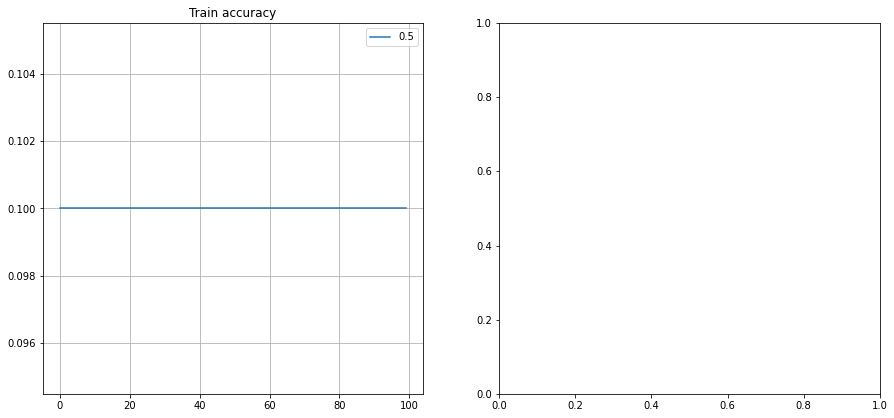

In [5]:
figname= f"test_seed10.png"
dico = np.load("summary_resnet32.npy", allow_pickle=True)
eval_plot(dico.item(), figname, scratch = True)

In [13]:
dico.item().get('P_factor_0.6_hist')

(array([0.09998   , 0.09999091, 0.09999412, 0.09999565, 0.09999655,
        0.09999714, 0.09999756, 0.09999787, 0.09999812, 0.0999983 ,
        0.09999846, 0.09999859, 0.0999987 , 0.09999879, 0.09999888,
        0.09999895, 0.09999901, 0.09999906, 0.09999911, 0.09999916,
        0.0999992 , 0.09999923, 0.09999927, 0.0999993 , 0.09999933,
        0.09999935, 0.09999938, 0.0999994 , 0.09999942, 0.09999944,
        0.09999946, 0.09999948, 0.09999949, 0.09999951, 0.09999952,
        0.09999953, 0.09999955, 0.09999956, 0.09999957, 0.09999958,
        0.09999959, 0.0999996 , 0.09999961, 0.09999962, 0.09999963,
        0.09999964, 0.09999964, 0.09999965, 0.09999966, 0.09999967,
        0.09999967, 0.09999968, 0.09999968, 0.09999969, 0.0999997 ,
        0.0999997 , 0.0999997 , 0.09999971, 0.09999972, 0.09999972,
        0.09999973, 0.09999973, 0.09999973, 0.09999974, 0.09999974,
        0.09999975, 0.09999975, 0.09999976, 0.09999976, 0.09999976,
        0.09999976, 0.09999977, 0.09999977, 0.09